In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.getcwd())

/content


In [ ]:
# Change to a new directory

os.chdir('/content/drive/My Drive/Colab Notebooks/Grace')

Data Analysis and Visualization in Jupyter:

In [ ]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Reading the datasets collected from Flask App

user_data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Module 7 project/user_data.xlsx')



In [ ]:
user_data

,Age,Gender,Income,Utilities,Entertainment,School Fees,Shopping,Healthcare
0,20,male,100000,on,on,on,on,on
1,45,male,200000,on,on,on,on,on
2,45,male,500000,on,on,on,on,on
3,36,female,250000,on,on,on,on,on
4,45,female,150000,on,on,on,on,on
5,50,female,50000,on,on,on,on,on
6,27,male,29000,on,on,on,on,on
7,40,male,30000,on,on,on,on,on
8,60,male,60000,on,on,on,on,on
9,30,male,100000,on,on,on,on,on


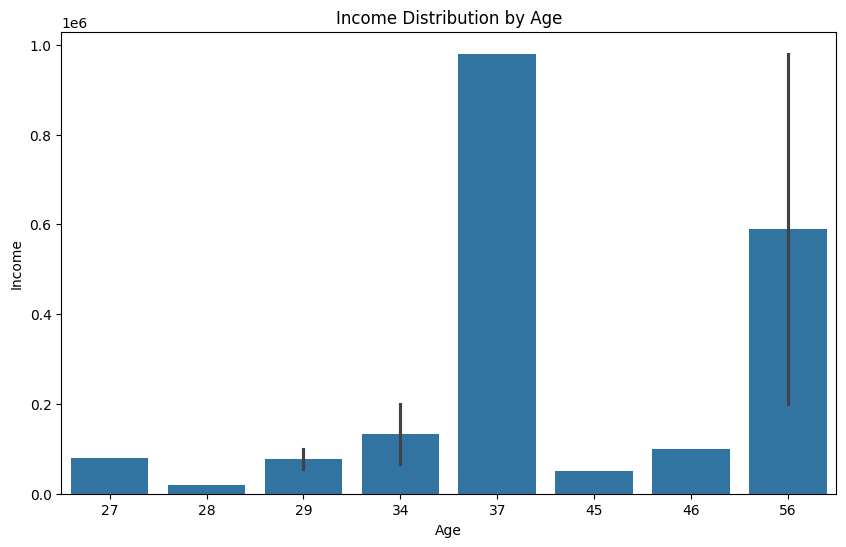

In [ ]:
# Visualizing Age vs Income

plt.figure(figsize=(10, 6))

sns.barplot(x='Age', y='Income', data=user_data)

plt.title('Income Distribution by Age')
plt.show()

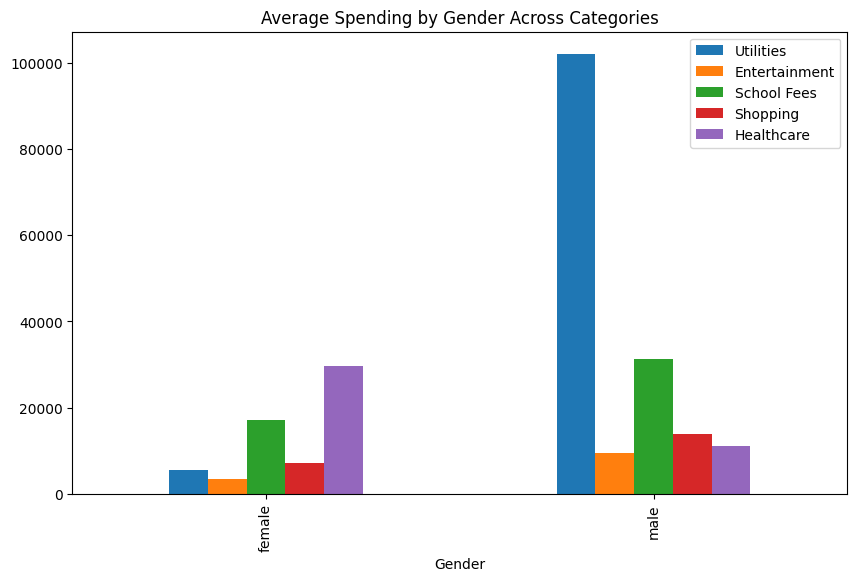

In [ ]:
# Sex distribution across spending categories

spending_columns = ['Utilities', 'Entertainment', 'School Fees', 'Shopping', 'Healthcare']

user_data.groupby('Gender')[spending_columns].mean().plot(kind='bar', figsize=(10, 6))

plt.title('Average Spending by Gender Across Categories')

plt.show()

App.py

In [ ]:
from flask import Flask, render_template, request, send_file
from pymongo import MongoClient
from user import User  # Import the User class
from datetime import datetime
import csv
import os

app = Flask(__name__)

# MongoDB setup
client = MongoClient('mongodb://localhost:27017/')
db = client['survey_db']
collection = db['user_data']

@app.route('/')
def index():
    # Get today's date
    today_date = datetime.today().strftime('%Y-%m-%d')  # Format: YYYY-MM-DD
    return render_template('index.html', date=today_date)


@app.route('/submit', methods=['POST'])
def submit():
    # Retrieve form data
    age = request.form['age']
    gender = request.form['gender']
    income = request.form['income']

    # Capture expenses based on the checkboxes
    expenses = {}

    if 'utilities' in request.form:
        expenses['utilities'] = float(request.form['utilities_amount']) if request.form['utilities_amount'] else 0
    if 'entertainment' in request.form:
        expenses['entertainment'] = float(request.form['entertainment_amount']) if request.form['entertainment_amount'] else 0
    if 'school_fees' in request.form:
        expenses['school_fees'] = float(request.form['school_fees_amount']) if request.form['school_fees_amount'] else 0
    if 'shopping' in request.form:
        expenses['shopping'] = float(request.form['shopping_amount']) if request.form['shopping_amount'] else 0
    if 'healthcare' in request.form:
        expenses['healthcare'] = float(request.form['healthcare_amount']) if request.form['healthcare_amount'] else 0

    # Create a User object and save data to CSV
    user = User(age, gender, income, expenses)
    user.save_to_csv()  # Save data to CSV (Optional)

    # Save data to MongoDB
    collection.insert_one({
        'age': age,
        'gender': gender,
        'income': income,
        'expenses': expenses
    })

    return "Data submitted successfully!"



@app.route('/export', methods=['GET'])
def export():
    # Define the CSV file path
    csv_file_path = 'exported_data.csv'

    # Fetch all data from MongoDB
    users = collection.find()  # Retrieve all documents from the 'user_data' collection

    # Open CSV file and write the data
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(['Age', 'Gender', 'Income', 'Utilities', 'Entertainment', 'School Fees', 'Shopping', 'Healthcare'])

        # Write data from MongoDB to CSV
        for user in users:
            writer.writerow([
                user.get('age', ''),
                user.get('gender', ''),
                user.get('income', ''),
                user['expenses'].get('utilities', ''),
                user['expenses'].get('entertainment', ''),
                user['expenses'].get('school_fees', ''),
                user['expenses'].get('shopping', ''),
                user['expenses'].get('healthcare', '')
            ])

    # Return the CSV file as a download
    return send_file(csv_file_path, as_attachment=True, download_name='user_data.csv')

if __name__ == '__main__':
    app.run(debug=True)

User.py

In [ ]:
import csv

class User:
    def __init__(self, age, gender, income, expenses):
        self.age = age
        self.gender = gender
        self.income = income
        self.expenses = expenses

    def save_to_csv(self, filename='user_data.csv'):
        with open(filename, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([self.age, self.gender, self.income, *self.expenses.values()])


index.html

In [ ]:

<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Personal Survey Application</title>
    <!-- Link to the CSS file -->
    <link rel="stylesheet" href="{{ url_for('static', filename='styles.css') }}">
</head>
<body>
    <h1>Welcome to Personal Survey: {{ date }}</h1>
    <h3>The aim is to collect Income and Expense Data</h3>

    <div class="form-container">
        <form action="/submit" method="POST">
            <label for="age">Your Age:</label>
            <input type="number" id="age" name="age" required>

            <label for="gender">Your Gender:</label>
            <select id="gender" name="gender" required>
                <option value="male">Male</option>
                <option value="female">Female</option>
                <option value="None">Non-binary</option>
            </select>

            <label for="income">Monthly Household Income KES:</label>
            <input type="number" id="income" name="income" required>

            <label for="expenses">Monthly Household Expenses KES: Tick each expense category and enter amount</label>
            <div class="checkbox-group">
                <div>
                    <input type="checkbox" id="utilities" name="utilities">
                    <label for="utilities">Utilities</label>
                    <input type="number" name="utilities_amount" placeholder="Amount" min="0" step="any">
                </div>
                <div>
                    <input type="checkbox" id="entertainment" name="entertainment">
                    <label for="entertainment">Entertainment</label>
                    <input type="number" name="entertainment_amount" placeholder="Amount" min="0" step="any">
                </div>
                <div>
                    <input type="checkbox" id="school_fees" name="school_fees">
                    <label for="school_fees">School Fees</label>
                    <input type="number" name="school_fees_amount" placeholder="Amount" min="0" step="any">
                </div>
                <div>
                    <input type="checkbox" id="shopping" name="shopping">
                    <label for="shopping">Shopping</label>
                    <input type="number" name="shopping_amount" placeholder="Amount" min="0" step="any">
                </div>
                <div>
                    <input type="checkbox" id="healthcare" name="healthcare">
                    <label for="healthcare">Healthcare</label>
                    <input type="number" name="healthcare_amount" placeholder="Amount" min="0" step="any">
                </div>
            </div>

            <input type="submit" value="Submit">
        </form>
    </div>

    <!-- Button to export CSV -->
    <div class="export-container">
        <form action="/export" method="GET">
            <button type="submit">Export CSV</button>
        </form>
    </div>

    <h3>@Grace Kamau: Date: {{ date }}</h3>
</body>
</html>


CSS

In [ ]:
/* Page Styles */
        body {
            font-family: 'Arial', sans-serif;
            background-color: #f0f4f8;
            margin: 0;
            padding: 40px;
            color: #333;
        }

        h1{
            text-align: center;
            color: #4a90e2;
            font-size: 25px;
        }
        h3{
            text-align: center;
            color: #4a90e2;
            font-size: 20px;
        }


        /* Form Container */
        .form-container {
            background-color: #ffffff;
            padding: 20px;
            border-radius: 10px;
            max-width: 600px;
            margin: auto;
            box-shadow: 0 4px 10px rgba(0, 0, 0, 0.1);
            border: 1px solid #d1dce3;
        }
            /* csv export */
        .export-container
        {
            background-color: #ffffff;
            padding: 20px;
            border-radius: 10px;
            max-width: 600px;
            margin: auto;
            box-shadow: 0 4px 10px rgba(0, 0, 0, 0.1);
            border: 1px solid #d1dce3;
        }

        form label {
            display: block;
            margin-bottom: 8px;
            font-weight: bold;
            color: #4a4a4a;
        }

        form input[type="number"],
        form input[type="text"],
        form select {
            width: 100%;
            padding: 10px;
            margin-bottom: 8px;
            border-radius: 5px;
            border: 1px solid #d1dce3;
            font-size: 12px;
            background-color: #f9fafb;
        }

        form input[type="checkbox"] {
            margin-right: 10px;
        }

        .checkbox-group div {
            display: flex;
            align-items: center;
            justify-content: space-between;
            margin-bottom: 15px;
        }

        .checkbox-group input[type="number"] {
            width: 80px;
            margin-left: 10px;
        }

        /* Submit Button */
        input[type="submit"] {
            background-color: #4a90e2;
            color: white;
            padding: 12px 10px;
            border: none;
            border-radius: 5px;
            cursor: pointer;
            font-size: 12px;
            width: 100%;
            transition: background-color 0.3s ease;
        }


        input[type="submit"]:hover {
            background-color: #357ab8;
        }

        /* Hover Effects */
        form input[type="number"],
        form input[type="text"],
        form select {
            transition: border 0.3s ease, background-color 0.3s ease;
        }

        form input[type="number"]:focus,
        form input[type="text"]:focus,
        form select:focus {
            border: 1px solid #4a90e2;
            background-color: #ffffff;
            outline: none;
        }

        /* Responsive */
        @media (max-width: 768px) {
            .form-container {
                padding: 15px;
            }

            input[type="submit"] {
                font-size: 16px;
            }
        }

